<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/bt_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

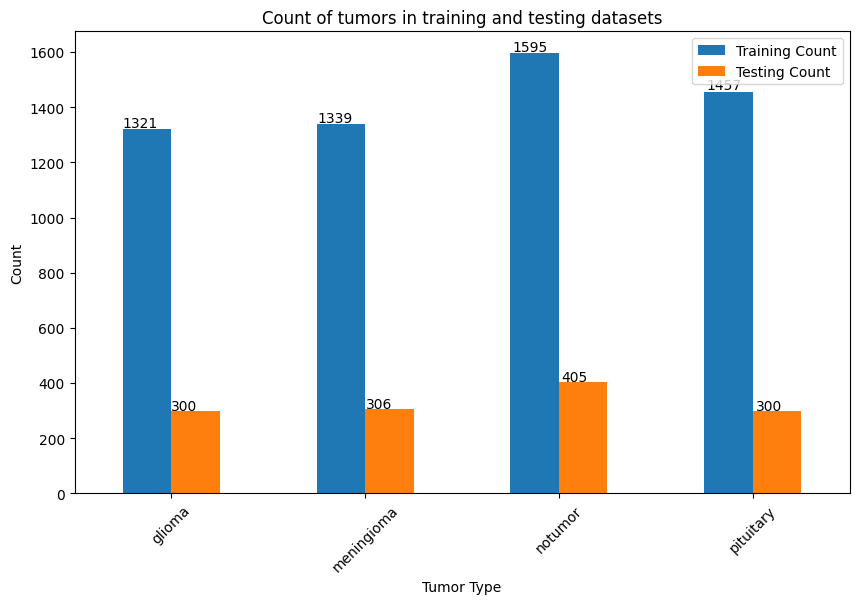

In [55]:
def get_images(directory_path):
    count_image_dict = {}
    img_paths = []
    img_labels = []
    for class_img_dir in os.listdir(directory_path):
        class_img_path = os.path.join(directory_path, class_img_dir)
        if os.path.isdir(class_img_path):
            count_image_dict[class_img_dir] = len(os.listdir(class_img_path))
            for img_name in os.listdir(class_img_path):
                img_paths.append(os.path.join(class_img_path, img_name))
                img_labels.append(class_img_dir)
    return count_image_dict, img_paths, img_labels

training_count, training_img_paths, training_label = get_images(training_path)
testing_count, testing_image_paths, testing_label = get_images(testing_path)

training_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
testing_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

combined_data_df = pd.merge(training_data_df, testing_data_df, on='Tumor Type')
combined_data_df.set_index('Tumor Type', inplace=True)

axes = combined_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of tumors in training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in axes.patches:
    axes.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [56]:
unique_names = list(set(training_label))
print('unique names: ', unique_names)
class_naming = {label: idx for idx, label in enumerate(unique_names)}
print('class naming: ', class_naming)

training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

unique names:  ['meningioma', 'notumor', 'glioma', 'pituitary']
class naming:  {'meningioma': 0, 'notumor': 1, 'glioma': 2, 'pituitary': 3}


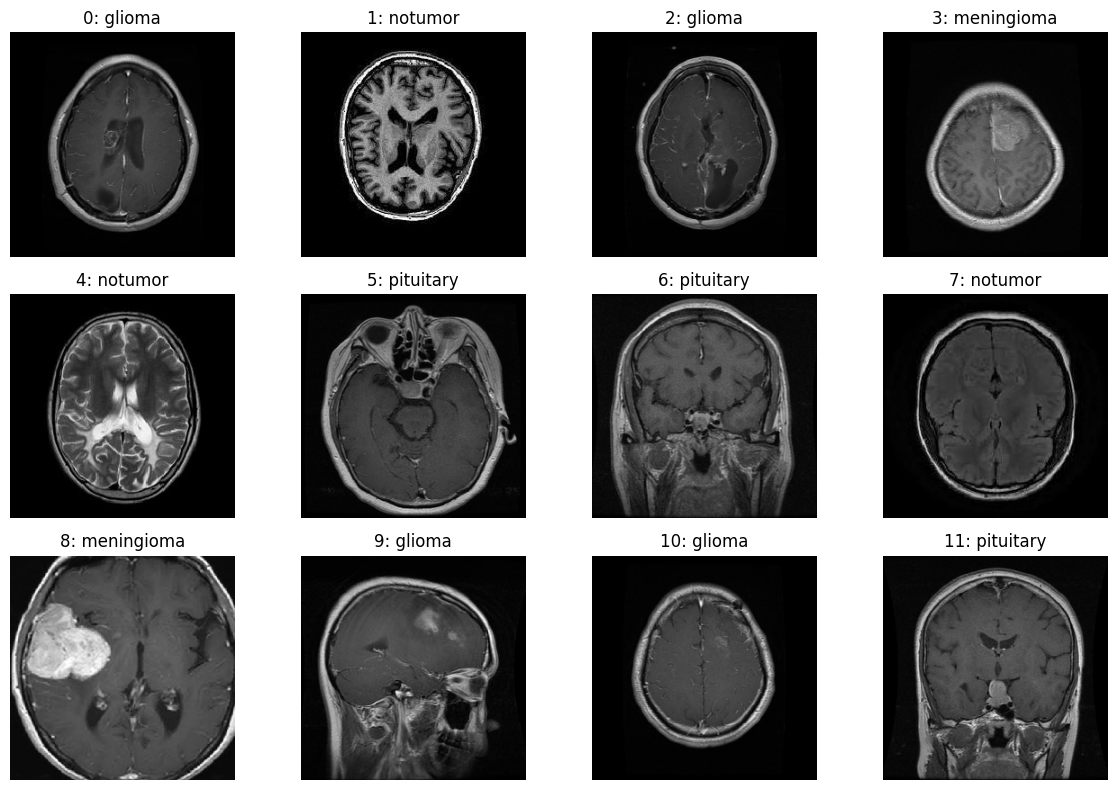

In [57]:
def show_img(path, label_indx, class_naming, index_list=range(10), img_size=250, figsize=(12, 8)):
    num_img = len(index_list)
    rows = (num_img + 3) // 4
    indx_to_class = {v: k for k, v in class_naming.items()}
    _, axes = plt.subplots(nrows=rows, ncols=4, figsize=figsize)
    axes = axes.flatten()

    for i, index in enumerate(index_list):
        if i >= num_img or index >= len(path):
            axes[i].axis('off')
            continue
        image = load_img(path[index], target_size=(img_size, img_size))
        axes[i].imshow(image)
        class_name = indx_to_class[label_indx[index]]
        axes[i].set_title(f'{index}: {class_name}')
        axes[i].axis('off')

    for j in range(num_img, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_img_paths, training_label_indx))
random.shuffle(combined)
training_img_paths, training_label_indx = zip(*combined)
show_img(training_img_paths, training_label_indx, class_naming, index_list=range(12))

In [58]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

In [59]:
image_dim = (250, 250)
batch_size = 32

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_dim)
    return image, label

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

training_img_paths = np.array(training_img_paths)
training_label_indx = np.array(training_label_indx)
testing_img_paths = np.array(testing_image_paths)
testing_label_indx = np.array(testing_label_indx)

train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_img_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

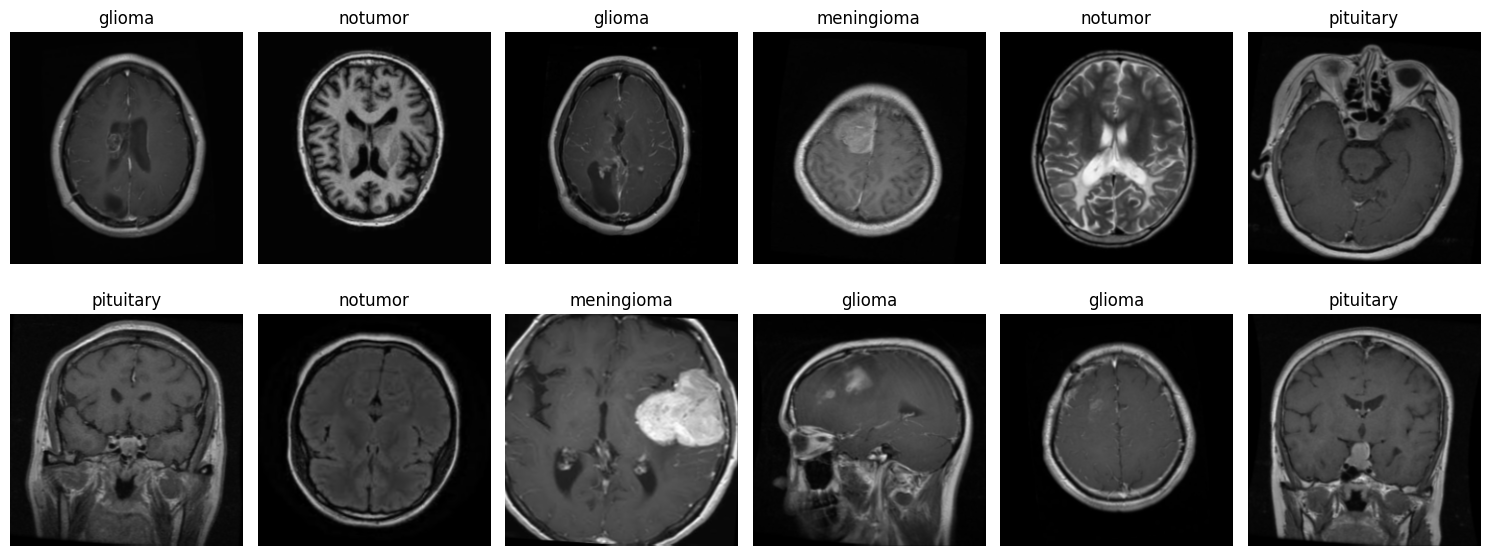

In [60]:
def plot_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    indx_to_class = {v: k for k, v in class_naming.items()}
    for images, label in dataset.take(1):
        for i in range(shape[0] * shape[1]):
            axes = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze())
            plt.title(indx_to_class[label.numpy()[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_naming=class_naming)

In [61]:
num_classes = len(class_naming.keys())
image_shape = (image_dim[0], image_dim[1], 3)
epochs = 50

inv_class_naming = {v: k for k, v in class_naming.items()}
print(f'Inverse class mappings: {inv_class_naming}')

print(f'Number of Classes: {num_classes}')
print(f'Epochs: {epochs}')
# print(f'Batch size: {batch_size}')


Inverse class mappings: {0: 'meningioma', 1: 'notumor', 2: 'glioma', 3: 'pituitary'}
Number of Classes: 4
Epochs: 50


In [62]:
def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [63]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

In [64]:
input_shape = (image_dim[0], image_dim[1], 3)
model = create_cnn_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

In [66]:
thresholds = [0.96, 0.99, 0.9935]
model_file = 'cnn_model.keras'
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint(model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

In [67]:
# Train the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.5966 - loss: 1.0369 - val_accuracy: 0.7696 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.8181 - loss: 0.4733 - val_accuracy: 0.7925 - val_loss: 0.5785 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.8748 - loss: 0.3375 - val_accuracy: 0.8871 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.9091 - loss: 0.2509 - val_accuracy: 0.8978 - val_loss: 0.3120 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.9385 - loss: 0.1749 - val_accuracy: 0.9054 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.9335 - loss: 0.1735 - val_accuracy: 0.9550 - val_loss: 0.1596 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.9

In [68]:
# Load the best model
cnn_model = load_model('cnn_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9934 - loss: 0.0551
Test accuracy: 99.2372%


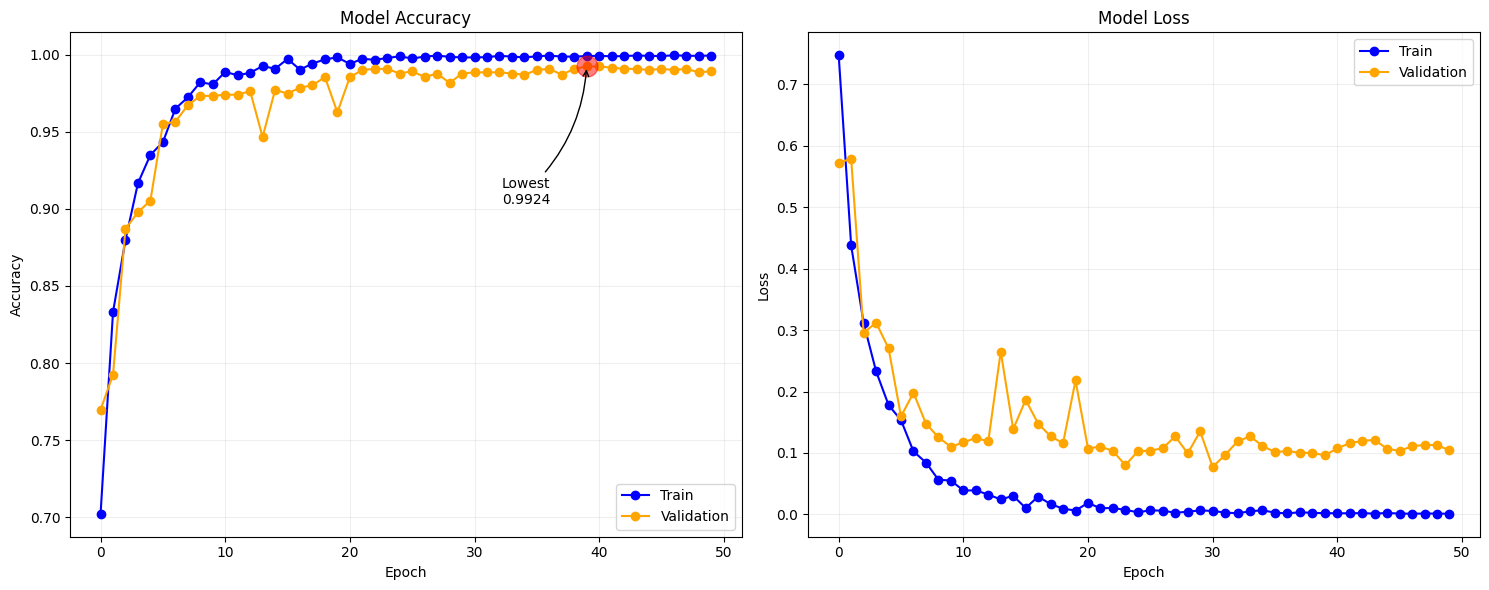

In [69]:
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [70]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [71]:
def plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_naming
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"Class: {class_name}")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"Overall Accuracy: {accuracy:.4f}")

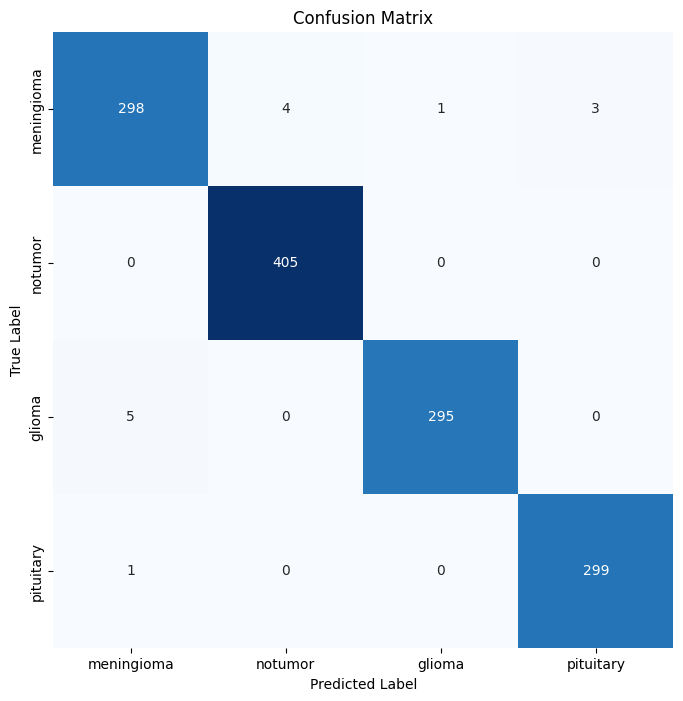

Class-wise metrics:
Class: meningioma
Precision: 0.9803
Recall: 0.9739
F1-Score: 0.9770

Class: notumor
Precision: 0.9902
Recall: 1.0000
F1-Score: 0.9951

Class: glioma
Precision: 0.9966
Recall: 0.9833
F1-Score: 0.9899

Class: pituitary
Precision: 0.9901
Recall: 0.9967
F1-Score: 0.9934

Overall Accuracy: 0.9893


In [72]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_naming,
                      metrics=True)

In [98]:
def plot_sample_predictions(model, folder_path, indx_to_class, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    image_files = []
    true_labels = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for image_file in os.listdir(subfolder_path):
            if image_file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_files.append(os.path.join(subfolder_path, image_file))
                true_labels.append(subfolder)

    num_samples = len(image_files)
    if num_samples == 0:
        print("No images found in the specified folder.")
        return

    num_cols = int(np.sqrt(num_samples))
    rows = (num_samples // num_cols) + (num_samples % num_cols > 0)

    for i, image_path in enumerate(image_files):
        img = Image.open(image_path).resize((250, 250))  # Resize to 250x250
        img_array = np.array(img) / 255.0  # Normalize the image
        img_batch = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        predicted_class = indx_to_class[predicted_label]

        true_class = true_labels[i]

        plt.subplot(rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPredicted: {predicted_class}", color='green')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


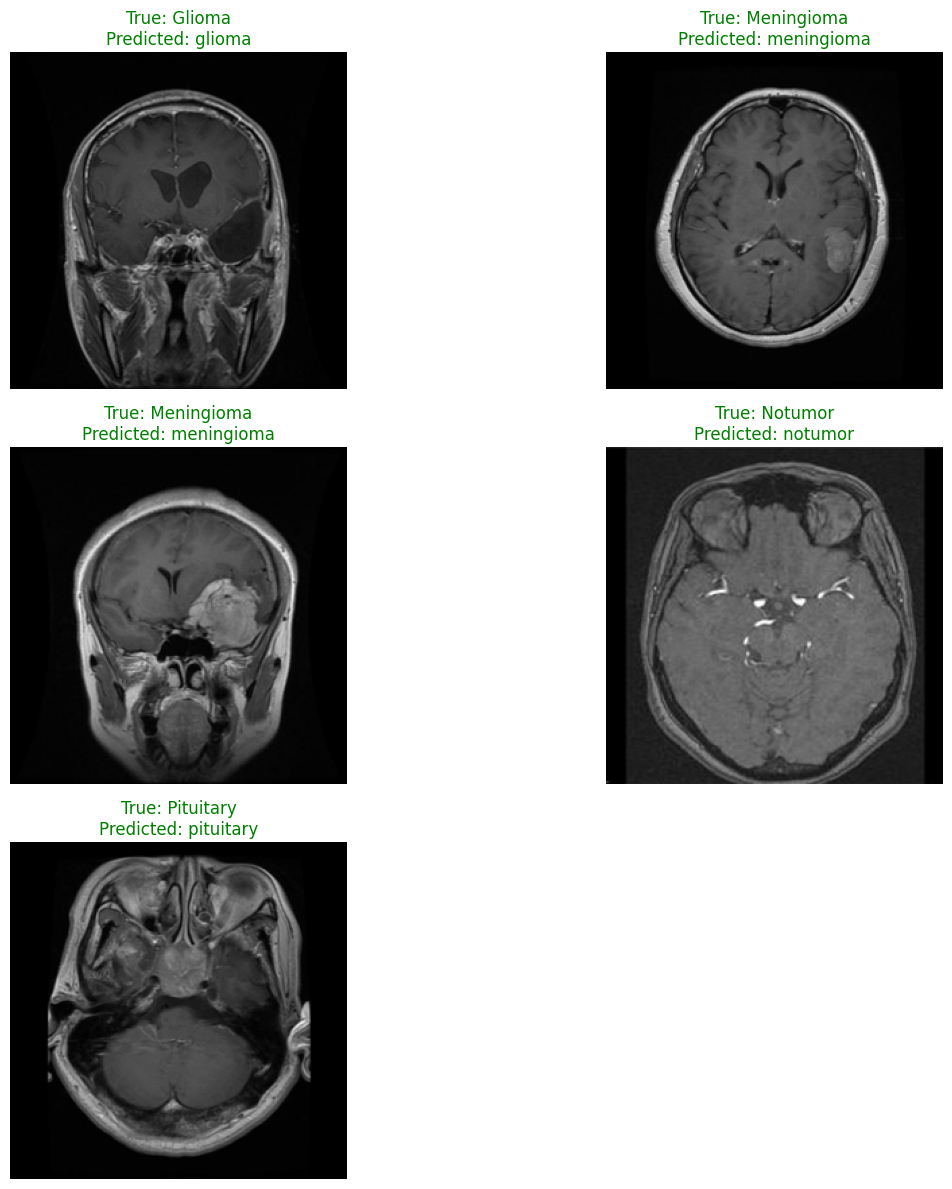

In [99]:
# Plottinng samples with predictions
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
plot_sample_predictions(cnn_model, prediction_folder, inv_class_naming, figsize=(13, 12))

In [87]:
def plot_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(indx_to_class[true_class_index])
            misclassified_predictions.append(indx_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

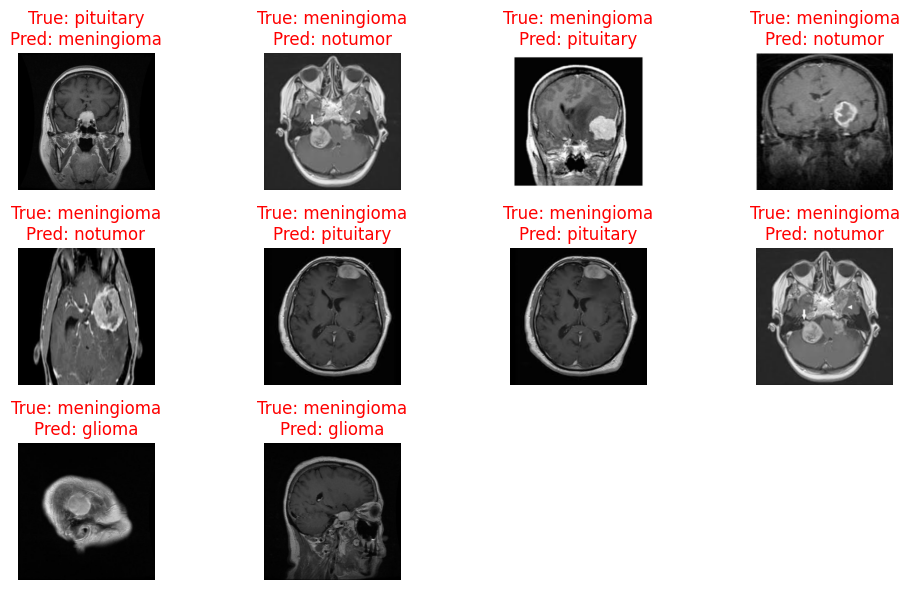

In [88]:
plot_misclassified_samples(model=cnn_model,
                           dataset=test_ds_preprocessed,
                           indx_to_class=inv_class_naming,
                           figsize=(10, 6))

In [90]:
# VGG16 Model Definition
def create_cnn_vgg16_model(input_shape, num_classes):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    # Freeze all the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze the last few layers of the base model
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [91]:
# input_shape = (image_dim[0], image_dim[1], 3)
epochs = 10
vgg16_model = create_cnn_vgg16_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

thresholds = [0.96, 0.99, 0.9935]
vgg16_model_file = 'cnn_vgg16_model.keras'
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint(vgg16_model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)
# print('model_mc ', model_mc)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [92]:
# Train the model
vgg16_history = vgg16_model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)
# Load the best model
cnn_vgg16_model = load_model(vgg16_model_file)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_vgg16_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 308ms/step - accuracy: 0.6974 - loss: 0.7465 - val_accuracy: 0.8581 - val_loss: 0.4122 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.9055 - loss: 0.2477 - val_accuracy: 0.9268 - val_loss: 0.2183 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.9493 - loss: 0.1374 - val_accuracy: 0.9359 - val_loss: 0.1496 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.9668 - loss: 0.0952 - val_accuracy: 0.9451 - val_loss: 0.1464 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.9669 - loss: 0.0816 - val_accuracy: 0.9405 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.9800 - loss: 0.0623 - val_accuracy: 0.9733 - val_loss: 0.0694 - learning_rate: 1.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 19

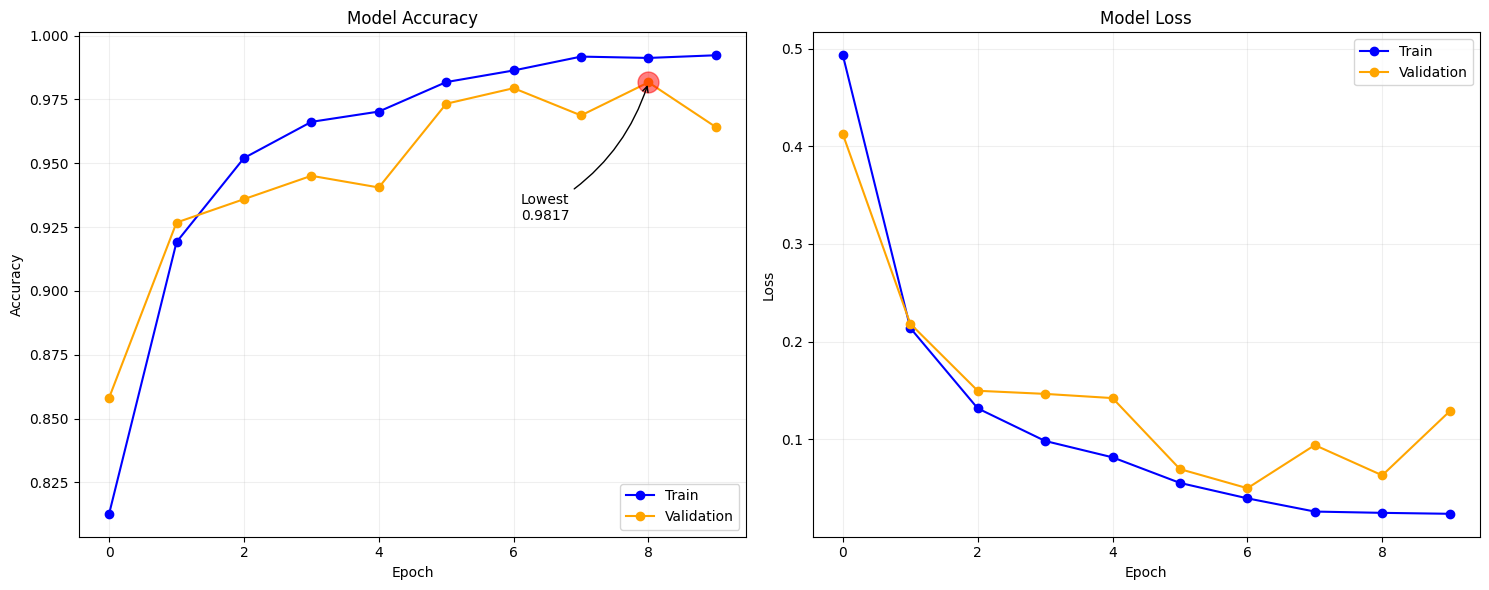

In [93]:
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(vgg16_history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(vgg16_history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(vgg16_history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(vgg16_history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(vgg16_history.history['val_accuracy'])
min_val_acc = np.max(vgg16_history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [94]:
# Using test data for true and predictions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = vgg16_model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

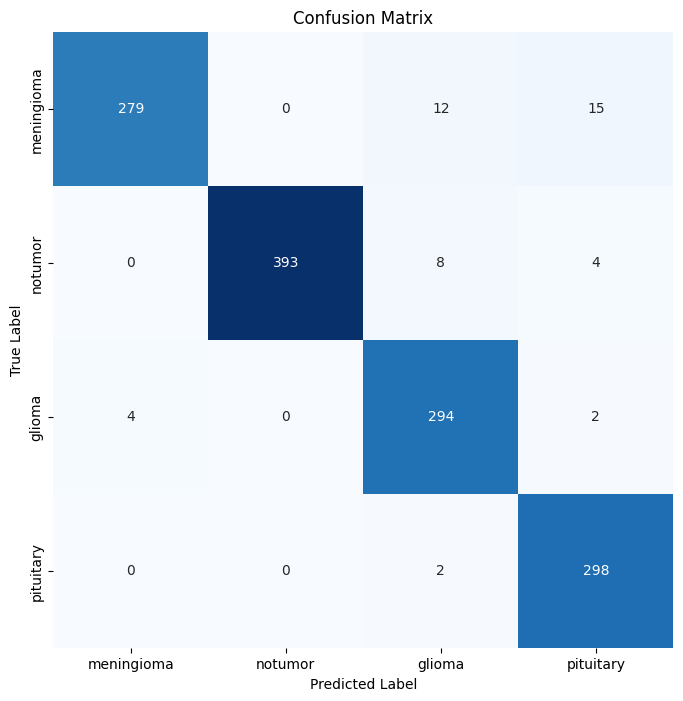

Class-wise metrics:
Class: meningioma
Precision: 0.9859
Recall: 0.9118
F1-Score: 0.9474

Class: notumor
Precision: 1.0000
Recall: 0.9704
F1-Score: 0.9850

Class: glioma
Precision: 0.9304
Recall: 0.9800
F1-Score: 0.9545

Class: pituitary
Precision: 0.9342
Recall: 0.9933
F1-Score: 0.9628

Overall Accuracy: 0.9641


In [95]:
# Plot confusion matrix for VGG16 Model
plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=True)

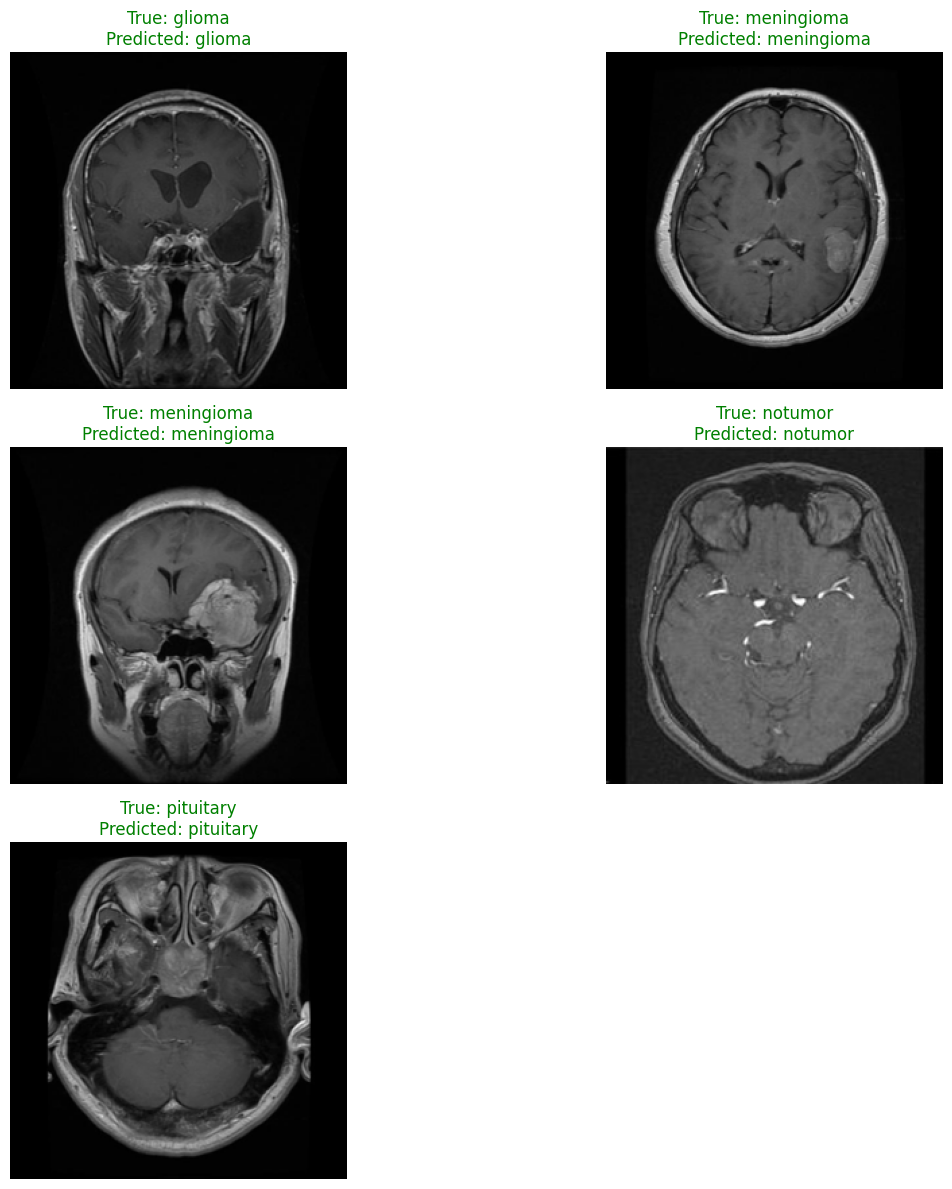

In [103]:
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
plot_sample_predictions(cnn_vgg16_model, prediction_folder, inv_class_naming, figsize=(13, 12))

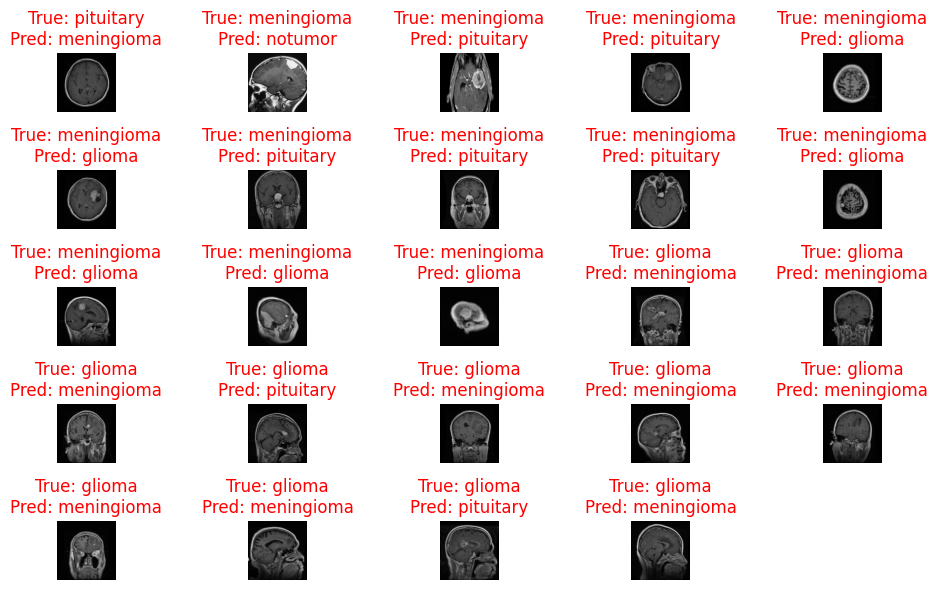

In [102]:
# Plotting samples with predictions
plot_misclassified_samples(model=cnn_vgg16_model, dataset=test_ds_preprocessed, indx_to_class=inv_class_naming, figsize=(10, 6))